Yol haritası:
* Data (UBIRIS V1)
-Preprocessing(centered, grayscale)
-Segmantasyon (İris ve Pupil) (Canny Edge - Hough Transform ile sınır tespiti)
-Normalization (Daugman's rubber sheet model)
-Feature Extraction (ResNet50)
-Model Training (ResNet50)
-Matching (ResNet50)




##Veri Analizi

Kullanılabilecek kütüphanelerin yüklenmesi

In [ ]:
## Visualization, sampling and data loading
import os
import PIL
import math
import cv2
import random
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## Data modeling
import tensorflow as tf
from keras import Sequential
from sklearn.model_selection import cross_val_score
from keras import backend as K
from tensorflow import keras as keras
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score,  roc_curve, confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.layers import Layer, Input, Dense,Dropout, Conv2D, BatchNormalization, Flatten, Input, Conv2D, GaussianNoise,MaxPooling2D, Flatten, Dense, Dropout

### Model evaluatoin
#from torchmetrics import Precision, Recall, Accuracy, AUROC
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.metrics')

import numpy as np
from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [ ]:
#merged_data = "/content/drive/MyDrive/Bil462_Proje/merged_participants"
combined_data = "/content/drive/MyDrive/Bil462_Proje/Combined"

In [ ]:
import os
import pandas as pd

# Ana klasör yolunu belirt
main_folder_path = "/content/drive/MyDrive/Bil462_Proje/Combined"

# Her katılımcı için resim sayısını tutmak için bir sözlük oluştur
participant_image_counts = {}

# Ana klasördeki her bir katılımcı klasörünü gez
for participant_folder in os.listdir(main_folder_path):
    participant_path = os.path.join(main_folder_path, participant_folder)

    # Eğer yol bir klasörse, bu klasörü işle
    if os.path.isdir(participant_path):
        # Katılımcı kimliğini al
        participant_id = participant_folder

        # Klasördeki tüm resim dosyalarını listele ve say
        images = [img for img in os.listdir(participant_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
        image_count = len(images)

        # Katılımcı kimliği ile resim sayısını sözlüğe ekle
        participant_image_counts[participant_id] = image_count

# Sözlüğü bir DataFrame'e dönüştür
image_counts_df = pd.DataFrame(list(participant_image_counts.items()), columns=['Participant_ID', 'Image_Count'])

# DataFrame'i görüntüle
print(image_counts_df)
print(image_counts_df[image_counts_df['Image_Count'] == max(image_counts_df['Image_Count'])])

    Participant_ID  Image_Count
0              101           10
1              105           10
2              100            5
3                1           10
4              107            5
..             ...          ...
241             99            5
242             95           10
243             96           10
244             94           10
245             97            5

[246 rows x 2 columns]
    Participant_ID  Image_Count
14             115           11
20             119           11
32             132           11
83              18           11
87             176           11
110            201           11
125             21           11
156            236           11
158            239           11
189             46           11


In [ ]:
import os
import pandas as pd

# Ana klasör yolunu belirt
main_folder_path = "/content/drive/MyDrive/Bil462_Proje/Combined"

# Tüm verileri saklamak için bir liste oluştur
combined_data = []

# Ana klasördeki her bir katılımcı klasörünü gez
for participant_folder in os.listdir(main_folder_path):
    participant_path = os.path.join(main_folder_path, participant_folder)

    # Eğer yol bir klasörse, bu klasörü işle
    if os.path.isdir(participant_path):
        # Katılımcı kimliğini al
        participant_id = participant_folder

        # Klasördeki tüm resim dosyalarını listele
        images = [os.path.join(participant_path, img) for img in os.listdir(participant_path) if img.endswith(('.png', '.jpg', '.jpeg'))]

        # DataFrame'e eklemek için bu katılımcıya ait bilgileri bir liste olarak oluştur
        row = [participant_id] + images
        combined_data.append(row)

# En uzun resim sayısına göre sütun adlarını ayarla
max_images = max(len(row) for row in combined_data) - 1  # Katılımcı ID hariç
columns = ['Participant_ID'] + [f'Iris_Image_{i+1}' for i in range(max_images)]

# DataFrame oluştur
iris_df = pd.DataFrame(combined_data, columns=columns)

# DataFrame'i görüntüle
iris_df


,Participant_ID,Iris_Image_1,Iris_Image_2,Iris_Image_3,Iris_Image_4,Iris_Image_5,Iris_Image_6,Iris_Image_7,Iris_Image_8,Iris_Image_9,Iris_Image_10,Iris_Image_11
0,101,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,None
1,105,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,None
2,100,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,None,None,None,None,None,None
3,1,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,None
4,107,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,/content/drive/MyDrive/Bil462_Proje/Combined/1...,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
241,99,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,None,None,None,None,None,None
242,95,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,None
243,96,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,None
244,94,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/MyDrive/Bil462_Proje/Combined/9...,/content/drive/M

In [ ]:
print("shape ",iris_df.shape)
print("describe ", iris_df.describe())
print("info ", iris_df.info())
print("columns ", iris_df.columns)

shape  (246, 12)
describe         Participant_ID                                       Iris_Image_1  \
count             246                                                246   
unique            246                                                246   
top               101  /content/drive/MyDrive/Bil462_Proje/Combined/1...   
freq                1                                                  1   

                                             Iris_Image_2  \
count                                                 246   
unique                                                246   
top     /content/drive/MyDrive/Bil462_Proje/Combined/1...   
freq                                                    1   

                                             Iris_Image_3  \
count                                                 246   
unique                                                246   
top     /content/drive/MyDrive/Bil462_Proje/Combined/1...   
freq                                      

## PreProcessing

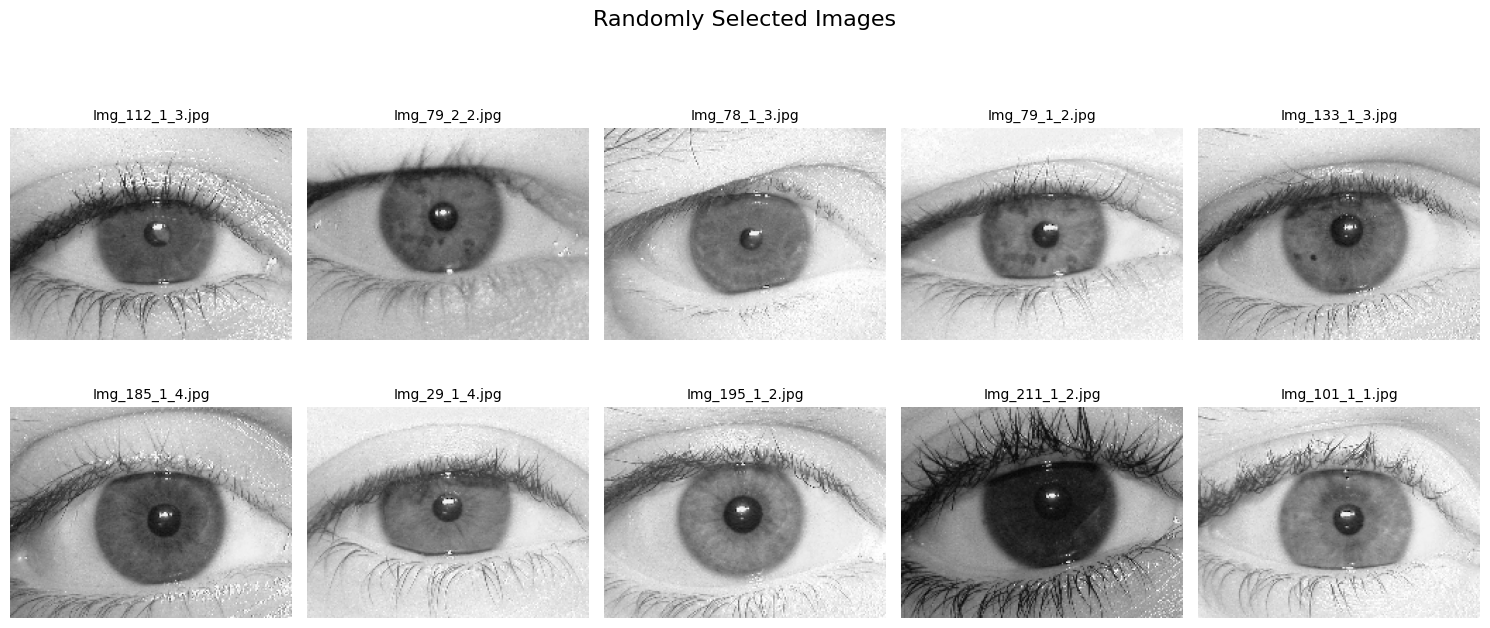

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt


# Rastgele seçilecek resim sayısı
num_images = 10

# Resim dosya yollarını depolamak için bir liste
image_paths = []

# Ana klasördeki her bir katılımcı klasörünü gez
for participant_folder in os.listdir(main_folder_path):
    participant_path = os.path.join(main_folder_path, participant_folder)

    # Eğer yol bir klasörse, bu klasördeki resimleri al
    if os.path.isdir(participant_path):
        images = [os.path.join(participant_path, img) for img in os.listdir(participant_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
        image_paths.extend(images)

# Belirtilen sayıda rastgele resim seç
selected_images = random.sample(image_paths, num_images)

# Kolaj için grid boyutlarını ayarla
cols = 5
rows = (num_images // cols) + (num_images % cols > 0)

# Görsel boyutlarını ayarla ve bir figür oluştur
fig, axes = plt.subplots(rows, cols, figsize=(15, 7))
fig.suptitle("Randomly Selected Images", fontsize=16)

# Resimleri grid üzerine yerleştir
for i, image_path in enumerate(selected_images):
    # Resmi oku ve BGR'den RGB'ye çevir
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Dosya adını görüntüle
    file_name = os.path.basename(image_path)

    # Axes düzenlemesini hesapla
    ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
    ax.imshow(image)
    ax.set_title(file_name, fontsize=10)
    ax.axis("off")

# Boş kalan grid hücrelerini kapat
for j in range(i + 1, rows * cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

**Farklı Teeknikler ile Sınırları Belirginleştirme**

In [ ]:

pre_processed_images = []
for i, image_path in enumerate(selected_images):
    # Orijinal resmi yükleme ve gri tonlamaya çevirme
    image = cv2.imread(image_path)
    file_name = os.path.basename(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Çeşitli görüntü işleme işlemleri
    equalized_image = cv2.equalizeHist(gray_image)  # Histogram eşitleme
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray_image)  # CLAHE uygulama
    blurred_image = cv2.GaussianBlur(equalized_image, (9, 9), 2)  # Gaussian Blur uygulama
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened_image = cv2.filter2D(gray_image, -1, kernel)  # Sharpened Image
    gamma_corrected = np.array(255 * (gray_image / 255) ** 0.5, dtype='uint8')  # Gamma Correction
    adaptive_thresh = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY_INV, 11, 2)  # Adaptive Threshold

    # İşlenmiş tüm görüntüleri bir listede saklama
    processed_images = [gray_image, equalized_image, clahe_image, blurred_image,
                        sharpened_image, gamma_corrected, adaptive_thresh]
    titles = ["Original", "Equalized", "CLAHE", "Blurred", "Sharpened", "Gamma Corrected", "Adaptive Threshold"]
    pre_processed_images.append((processed_images))
    # Görselleri bir satıra yerleştirerek gösterme
    fig, axs = plt.subplots(1, len(processed_images), figsize=(20, 5))
    fig.suptitle(f"Processed Images for {file_name}", fontsize=16)

    for idx, (proc_img, title) in enumerate(zip(processed_images, titles)):
        if len(proc_img.shape) == 2:  # Gri tonlamalı resimler için
            axs[idx].imshow(proc_img, cmap='gray')
        else:  # Renkli resim için
            axs[idx].imshow(cv2.cvtColor(proc_img, cv2.COLOR_BGR2RGB))
        axs[idx].set_title(title)
        axs[idx].axis('off')

    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(len(pre_processed_images))
print(len(pre_processed_images[0]))

10
7


##Iris tespiti için deneme ve performans analizi

In [ ]:
pupil_circles = cv2.HoughCircles(
    adaptive_thresh,
    cv2.HOUGH_GRADIENT,
    dp=1.1,
    minDist=20,
    param1=100,
    param2=50,    # Duyarlılığı artırmak için daha düşük bir değer
    minRadius=10, # Daha küçük bir minimum yarıçap
    maxRadius=30  # Maksimum yarıçap
)

# Göz bebeği tespit edilirse göster
if pupil_circles is not None:
    pupil_circles = np.round(pupil_circles[0, :]).astype("int")
    for (x, y, r) in pupil_circles:
        cv2.circle(adaptive_thresh, (x, y), r, (255, 0, 0), 2)  # Göz bebeği çevresi
        cv2.circle(adaptive_thresh, (x, y), 2, (0, 0, 255), 3)  # Göz bebeği merkezi
    print("Göz bebeği merkezi ve yarıçap:", (x, y), r)
else:
    print("Göz bebeği tespit edilemedi")

# Görüntüyü gösterme
#cv2_imshow(adaptive_thresh)

Göz bebeği tespit edilemedi


Göz bebeği merkezi ve yarıçap: (91, 138) 12


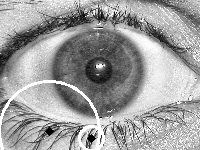

In [ ]:
adaptive_thresh = cv2.adaptiveThreshold(
    clahe_image,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    11,
    2
)

# Eşiklenen görüntüde kontur bulma
contours, _ = cv2.findContours(adaptive_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    (x, y), radius = cv2.minEnclosingCircle(contour)
    center = (int(x), int(y))
    radius = int(radius)

    # Göz bebeği boyutuna uygun kontur olup olmadığını kontrol etme
    if 10 < radius < 40:  # Göz bebeğine uygun bir yarıçap aralığı
        cv2.circle(clahe_image, center, radius, (255, 0, 0), 2)
        cv2.circle(clahe_image, center, 2, (0, 0, 255), 3)
        print("Göz bebeği merkezi ve yarıçap:", center, radius)
        break

# Görüntüyü gösterme
cv2_imshow(clahe_image)

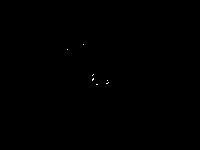

Göz bebeği tespit edilemedi


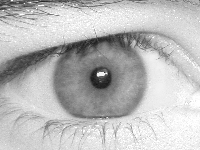

In [ ]:

# Göz bebeğini tespit etme örneği
image = cv2.imread("/content/drive/MyDrive/Bil462_Proje/Combined/10/Img_10_1_2.jpg")  # Görseli yükleyin
circles = detect_pupil_by_darkness(image)

# Eğer daireler tespit edildiyse, görsel üzerinde daireyi çizin
if circles is not None:
    for (x, y, r) in circles:
        cv2.circle(image, (x, y), r, (0, 255, 0), 4)  # Daireyi çiz
        cv2.circle(image, (x, y), 2, (0, 0, 255), 3)  # Merkezi işaretle
else:
    print("Göz bebeği tespit edilemedi")
# Görseli gösterme
cv2_imshow(image)


### Segmentation

Göz bebeği ve iris sınırını çizmek için iki farklı yöntem kullanılmıştır. Sadece hough kullanıldığında örnek resimlerde göz bebeğinin tespit başarısı düşük çıkmıştır. Canny edge ve circular hough kullanıldığında daha başarılı tespitler yapılmıştır.

cv2.findContours kullanarak daire değil, düzensiz sınırlar bulunabilir

#### Edge+Hough (Daha iyi çalışıtor)

In [ ]:
import cv2
import numpy as np
def detect_edges(image, lower_threshold, upper_threshold):
    # Kenar tespiti
    edges = cv2.Canny(image, lower_threshold, upper_threshold)
    return edges
def detect_circles(image, dp, minDist, param1, param2, minRadius, maxRadius):
    # Blur işlemi ile gürültü azaltma
    blurred_image = cv2.GaussianBlur(gray_image, (9, 9), 2)
    # Hough Circle Transform
    circles = cv2.HoughCircles(blurred_image, cv2.HOUGH_GRADIENT, dp, minDist,
                               param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
    return circles


###Edgelerin Belirlenmesi

In [ ]:
for i, processed_images in enumerate(pre_processed_images):
    # Subplot'lar için gerekli figür oluşturuluyor
    fig, axs = plt.subplots(1, len(processed_images), figsize=(15, 5))
    fig.suptitle(f"Processed Images for Participant {i+1}", fontsize=16)

    for j, img in enumerate(processed_images):
        # Kenarları tespit et
        edges = detect_edges(img, lower_threshold=100, upper_threshold=150)

        # Orijinal ve kenarları yan yana göstermek için
        axs[j].imshow(edges, cmap='gray')  # Kenarları gri tonlamada göster
        axs[j].set_title(f"Edges - Görsel {j+1}")
        axs[j].axis('off')  # Eksenleri kaldır

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

###Detect Circle

In [ ]:
filtered_preprocessed_images = []
for processed_images in pre_processed_images:
    filtered_images = [processed_images[0], processed_images[2], processed_images[5]]  # 1., 3., ve 6. görseller
    filtered_preprocessed_images.append(filtered_images)

Tespit edilen çemberlerden merkeze en yakın olanı seçmek

In [ ]:
for i, processed_images in enumerate(filtered_preprocessed_images):
    # Subplot'lar için figür oluşturuluyor
    fig, axs = plt.subplots(1, len(processed_images), figsize=(15, 5))
    fig.suptitle(f"Processed Images for Participant {i+1}", fontsize=16)

    for j, img in enumerate(processed_images):
        # Kenarları tespit et
        edges = detect_edges(img, lower_threshold=400, upper_threshold=500)

        # Hough ile daire tespiti
        circles = detect_circles(edges, dp=1.2, minDist=50, param1=100, param2=30, minRadius=20, maxRadius=50)

        if circles is not None:
            # Fotoğrafın merkezini bul
            center = (img.shape[1] // 2, img.shape[0] // 2)  # (x, y) koordinatları

            # Fotoğrafın merkezine en yakın çemberi seç
            closest_circle = None
            min_distance = float('inf')  # Başlangıçta sonsuz bir mesafe

            for (x, y, r) in circles:
                # Fotoğrafın merkezine olan mesafeyi hesapla
                distance = ((x - center[0]) ** 2 + (y - center[1]) ** 2) ** 0.5

                # En yakın çemberi seç
                if distance < min_distance:
                    min_distance = distance
                    closest_circle = (x, y, r)

            # En yakın çemberi çizme
            if closest_circle is not None:
                x, y, r = closest_circle
                # Daireyi çizme
                cv2.circle(img, (x, y), r, (0, 255, 0), 1)  # Yeşil daire
                # Merkezini işaretleme
                cv2.circle(img, (x, y), 2, (0, 0, 255), 1)  # Kırmızı merkez

        # Kenarları ve daireli görseli gösterme
        axs[j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Renkli gösterim
        axs[j].set_title(f"Edges and Circles - Görsel {j+1}")
        axs[j].axis('off')  # Eksenleri kaldır

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

iris tespiti sonrası irisin içerisinde pupil aramak



In [ ]:
for i, processed_images in enumerate(filtered_preprocessed_images):
    fig, axs = plt.subplots(1, len(processed_images), figsize=(15, 5))
    fig.suptitle(f"Processed Images for Participant {i+1}", fontsize=16)

    for j, img in enumerate(processed_images):
        # İlk olarak, iris dairesini bulalım (büyük daire)
        iris_circles = detect_circles(img, dp=1.2, minDist=50, param1=100, param2=30, minRadius=40, maxRadius=100)

        # Eğer iris tespit edilmişse, bu dairenin içinde pupil arayacağız
        if iris_circles is not None:
            for (x, y, r) in iris_circles:
                # İrisin çevresini çiz
                cv2.circle(img, (x, y), r, (0, 255, 0), 4)  # Yeşil daire
                # İrisin merkezini işaretle
                cv2.circle(img, (x, y), 2, (0, 0, 255), 3)  # Kırmızı merkez

                # Pupil tespiti: İrisin içinde daha küçük bir daire arayacağız
                pupil_circles = detect_circles(img, dp=1.2, minDist=20, param1=100, param2=30, minRadius=10, maxRadius=40)

                if pupil_circles is not None:
                    for (px, py, pr) in pupil_circles:
                        # Pupili çiz
                        cv2.circle(img, (px, py), pr, (255, 0, 0), 4)  # Mavi daire
                        # Pupilin merkezini işaretle
                        cv2.circle(img, (px, py), 2, (0, 0, 255), 3)  # Kırmızı merkez

        # Görselleştirme
        axs[j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Görüntüyü renkli olarak göster
        axs[j].set_title(f"Edges and Circles - Görsel {j+1}")
        axs[j].axis('off')  # Eksenleri kaldır

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def detect_circles_for_iris_and_pupil(image, iris_params, pupil_params):
    # Gri tonlama
    # Göz bebeği ve iris için daire tespiti
    # Iris için daire tespiti (büyük daireler)
    edges = cv2.Canny(image, 50, 150)

    iris_circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                                    param1=100, param2=30, minRadius=iris_params['min_radius'],
                                    maxRadius=iris_params['max_radius'])

    # Göz bebeği için daire tespiti (küçük daireler)
    pupil_circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                                     param1=100, param2=30, minRadius=pupil_params['min_radius'],
                                     maxRadius=pupil_params['max_radius'])

    circles = []
    if iris_circles is not None:
        iris_circles = np.round(iris_circles[0, :]).astype("int")
        circles.append(iris_circles[0])  # İris dairesi

    if pupil_circles is not None:
        pupil_circles = np.round(pupil_circles[0, :]).astype("int")
        circles.append(pupil_circles[0])  # Pupil dairesi

    # Çizim işlemi - Yalnızca ilk 2 daireyi çizme
    if len(circles) > 0:
        for (x, y, r) in circles:
            cv2.circle(image, (x, y), r, (0, 255, 0), 2)  # Çevreyi çiz
            cv2.circle(image, (x, y), 2, (0, 0, 255), 3)  # Merkezi işaretle

    return image, edges

Farklı preprocessing yöntemlerini ve farklı treshold ile tespit edilen irisleri incelemek

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Edge detection function
def detect_edges(image, lower_threshold, upper_threshold):
    # Gri tonlama

    # Kenar tespiti
    edges = cv2.Canny(image, lower_threshold, upper_threshold)
    return edges

# Circle detection function for iris and pupil
def detect_circles(image, dp, minDist, param1, param2, minRadius, maxRadius):
    # Gri tonlama

    # Blur işlemi ile gürültü azaltma
    blurred_image = cv2.GaussianBlur(image, (9, 9), 2)
    # Hough Circle Transform
    circles = cv2.HoughCircles(blurred_image, cv2.HOUGH_GRADIENT, dp, minDist,
                               param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")  # Daireleri yuvarlama ve int formatına dönüştür
    return circles

# Görseller üzerinde işlem yapmak ve sonuçları göstermek için
for i, processed_images in enumerate(pre_processed_images):
    for j, img in enumerate(processed_images):
        print(f"Katılımcı {i+1}, Görsel {j+1}")

        # Kenar tespiti
        edges = detect_edges(img, lower_threshold=50, upper_threshold=150)

        # Daire tespiti (İris için)
        iris_circles = detect_circles(img, dp=1.2, minDist=100, param1=100, param2=30, minRadius=20, maxRadius=50)
        pupil_circles = detect_circles(img, dp=1.2, minDist=100, param1=100, param2=30, minRadius=10, maxRadius=20)

        # Daireleri saklamak için liste
        circles = []

        # İris dairesi tespiti
        if iris_circles is not None:
            circles.append(iris_circles[0])  # İris dairesi (ilk daireyi alıyoruz)

        # Pupil dairesi tespiti
        if pupil_circles is not None:
            circles.append(pupil_circles[0])  # Pupil dairesi (ilk daireyi alıyoruz)

        # Daireler tespit edildiyse çizim işlemi yap
        if len(circles) > 0:
            for circle in circles:
                # Daireyi (x, y, r) olarak unpack et
                x, y, r = circle
                # Çevreyi çiz
                cv2.circle(img, (x, y), r, (0, 255, 0), 2)  # Çevreyi çiz
                # Merkezi işaretle
                cv2.circle(img, (x, y), 2, (0, 0, 255), 3)  # Merkezi işaretle

        # Görüntüleri gösterme
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        # Kenarları göster
        axs[0].imshow(edges, cmap='gray')
        axs[0].set_title(f"Edges - Katılımcı {i+1}, Görsel {j+1}")
        axs[0].axis('off')

        # Daireli Görüntü
        axs[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[1].set_title(f"Circles Detected - Katılımcı {i+1}, Görsel {j+1}")
        axs[1].axis('off')

        plt.show()


Output hidden; open in https://colab.research.google.com to view.

##Verilerin Test ve Train olarak ayrılması

Verilerin %80'i train, %20'si test olarak ayrılmıştır. Bu da genel olarak her iki oturuma katılan kişilerin 2 iris görseline, tek oturuma katılan kişilerin 1 iris görseline tekabül etmektedir. Görseller seçilirken oturumlar baz alınmamış olup rastgele seçilmiştir

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

base_dir = "/content/drive/MyDrive/Bil462_Proje/Combined"  # Görsellerin olduğu ana klasör
train_dir = "train_dataset_path"
test_dir = "test_dataset_path"

# Test oranı
test_ratio = 0.2

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


for participant_id in range(1, 247):  # 1'den 246'ya kadar
    participant_folder = os.path.join(base_dir, str(participant_id))

    if not os.path.exists(participant_folder):
        continue

    images = os.listdir(participant_folder)
    images = [img for img in images if img.endswith(('.jpg', '.png'))]

    train_images, test_images = train_test_split(images, test_size=test_ratio, random_state=42)


    for img in train_images:
        shutil.copy(os.path.join(participant_folder, img),
                    os.path.join(train_dir, f"{participant_id}_{img}"))

    for img in test_images:
        shutil.copy(os.path.join(participant_folder, img),
                    os.path.join(test_dir, f"{participant_id}_{img}"))

print("Veriler başarıyla ayrıldı.")


##Sonraki çalıştırmalar için zip oluşturma/ zip indirme

Zip formatında test ve train verilerinin indirilmesi - Zip dosyaların açılması

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile
import os

# Zip dosyası oluşturma fonksiyonu
def create_zip(source_dir, output_filename):
    with zipfile.ZipFile(output_filename, 'w') as zipf:
        for root, dirs, files in os.walk(source_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, start=source_dir)
                zipf.write(file_path, arcname)

# Eğitim ve test setlerini zip'e ekle
#create_zip("train_dataset_path", "train_dataset.zip")
create_zip("/content/test_processed_dataset", "test_processed_dataset.zip")

print("Zip dosyaları oluşturuldu.")


Zip dosyaları oluşturuldu.


In [ ]:
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zipf:
        zipf.extractall(extract_to)
    print(f"{zip_path} içeriği {extract_to} klasörüne çıkarıldı.")


/content/drive/MyDrive/Bil462_Proje/train_processed_dataset.zip içeriği train_deneme_dataset klasörüne çıkarıldı.
/content/drive/MyDrive/Bil462_Proje/test_processed_dataset.zip içeriği test_deneme_dataset klasörüne çıkarıldı.


In [ ]:
extract_zip("/content/drive/MyDrive/Bil462_Proje/train_dataset.zip", "train_dataset")
extract_zip("/content/drive/MyDrive/Bil462_Proje/test_dataset.zip", "test_dataset")

In [ ]:
import os

def get_file_count(folder_path):
    total_files = 0
    for _, _, filenames in os.walk(folder_path):
        total_files += len(filenames)  # Her klasördeki dosya sayısını topla
    return total_files

# Train ve Test dataset'lerinin dosya sayısını hesapla
train_dataset_path = "/content/train_deneme_dataset"
test_dataset_path = "/content/test_deneme_dataset"

train_files = get_file_count(train_dataset_path)
test_files = get_file_count(test_dataset_path)

print(f"Train Dataset: {train_files} dosya")
print(f"Test Dataset: {test_files} dosya")
print(f"Toplam: {train_files + test_files} dosya")



Train Dataset: 1480 dosya
Test Dataset: 382 dosya
Toplam: 1862 dosya


In [ ]:
import shutil
import os

def delete_folder_contents(folder_path):
    if os.path.exists(folder_path):
        # Klasör içeriğini temizle
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)  # Dosya veya bağlantıyı sil
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)  # Alt klasörü sil
            except Exception as e:
                print(f"Hata oluştu: {file_path} -> {e}")
        print(f"{folder_path} içeriği silindi.")
    else:
        print(f"{folder_path} mevcut değil.")

In [ ]:
delete_folder_contents("/content/data/val/images")

/content/data/val/images içeriği silindi.


##Preprocessing - Normalizasyon

Farklı preprocessing tekniklerini test ederek en iyi iris ve pupil tespiti sonucu veren tekniği bulmaya çalışıyoruz.

In [ ]:
import cv2
import os

# CLAHE işlemi
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)


In [ ]:
def apply_histogram_equalization(image):
    equalized = cv2.equalizeHist(image)
    return equalized

In [ ]:
def apply_sharpening(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])  # Sharpening kernel
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

In [ ]:
def apply_gamma_correction(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype("uint8")
    corrected = cv2.LUT(image, table)
    return corrected

İris ve pupil tespiti için canny edge detection ve circular hough transform kullanıldı

In [ ]:
def apply_canny(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    return edges



In [ ]:
import numpy as np

# Circular Hough Transform
def detect_circles(edge_image):
    # Hough Transform parametreleri
    circles = cv2.HoughCircles(
    edges,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=30,
    param1=100,  # Higher thresholds can reduce noise
    param2=30,   # Lower this if circles are missed
    minRadius=10,  # Adjust based on expected pupil/iris size
    maxRadius=100  # Adjust based on expected pupil/iris size
)

    if circles is not None and len(circles[0]) >= 2:
        return np.uint16(np.around(circles))
    else:
        return None



In [ ]:
def filter_circles(circles, min_radius, max_radius):
    filtered = []
    for c in circles[0]:
        x, y, r = int(c[0]), int(c[1]), int(c[2])
        if min_radius <= r <= max_radius:
            filtered.append((x, y, r))
    return filtered


Normalize etmek için Daugman's rubber sheet

In [ ]:
def rubber_sheet_normalization(image, center, inner_radius, outer_radius, output_shape=(64, 512)):
    normalized = np.zeros(output_shape, dtype=np.uint8)
    theta = np.linspace(0, 2 * np.pi, output_shape[1])
    r_values = np.linspace(inner_radius, outer_radius, output_shape[0])

    # Meshgrid oluştur: Her pikselin (x, y) koordinatlarını oluştur
    r_grid, theta_grid = np.meshgrid(r_values, theta)
    x = center[0] + r_grid * np.cos(theta_grid)
    y = center[1] + r_grid * np.sin(theta_grid)

    # Float32 formatına çevir ve sınırları kontrol et
    map_x = np.clip(x, 0, image.shape[1] - 1).astype(np.float32)
    map_y = np.clip(y, 0, image.shape[0] - 1).astype(np.float32)

    # cv2.remap ile normalizasyon
    normalized = cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR)
    return normalized


In [ ]:
train_dir = "/content/train_dataset"
no_circle_original = []
no_circle_clahe = []
no_circle_equalized = []
no_circle_sharpened = []
no_circle_gamma = []

for filename in os.listdir(train_dir):
    file_path = os.path.join(train_dir, filename)
    image = cv2.imread(file_path)

    # Orijinal görüntü ile çember tespiti
    edges_original = apply_canny(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    circles_original = detect_circles(edges_original)
    if circles_original is None:
        no_circle_original.append(filename)

    # CLAHE uygulanmış görüntü ile çember tespiti
    enhanced_clahe = apply_clahe(image)
    edges_clahe = apply_canny(enhanced_clahe)
    circles_clahe = detect_circles(edges_clahe)
    if circles_clahe is None:
        no_circle_clahe.append(filename)

    # Histogram eşitleme uygulanmış görüntü ile çember tespiti
    enhanced_equalized = apply_histogram_equalization(image)
    edges_equalized = apply_canny(enhanced_equalized)
    circles_equalized = detect_circles(edges_equalized)
    if circles_equalized is None:
        no_circle_equalized.append(filename)

    # Keskinleştirme uygulanmış görüntü ile çember tespiti
    enhanced_sharpened = apply_sharpening(image)
    edges_sharpened = apply_canny(cv2.cvtColor(enhanced_sharpened, cv2.COLOR_BGR2GRAY))
    circles_sharpened = detect_circles(edges_sharpened)
    if circles_sharpened is None:
        no_circle_sharpened.append(filename)

    # Gamma düzeltme uygulanmış görüntü ile çember tespiti
    enhanced_gamma = apply_gamma_correction(image, gamma=2.2)
    edges_gamma = apply_canny(cv2.cvtColor(enhanced_gamma, cv2.COLOR_BGR2GRAY))
    circles_gamma = detect_circles(edges_gamma)
    if circles_gamma is None:
        no_circle_gamma.append(filename)

# Çember bulunamayan görselleri yazdır
print("\nOrijinal Görsellerde Çember Bulunamayanlar:")
print(no_circle_original)

print("\nCLAHE Sonrası Görsellerde Çember Bulunamayanlar:")
print(no_circle_clahe)

print("\nHistogram Eşitleme Sonrası Görsellerde Çember Bulunamayanlar:")
print(no_circle_equalized)

print("\nKeskinleştirme Sonrası Görsellerde Çember Bulunamayanlar:")
print(no_circle_sharpened)

print("\nGamma Düzeltme Sonrası Görsellerde Çember Bulunamayanlar:")
print(no_circle_gamma)

print(f"Orijinal Görsellerde Çember Bulunamayanlar: {len(no_circle_original)}")
print(f"CLAHE Sonrası Görsellerde Çember Bulunamayanlar: {len(no_circle_clahe)}")
print(f"Histogram Eşitleme Sonrası Görsellerde Çember Bulunamayanlar: {len(no_circle_equalized)}")
print(f"Keskinleştirme Sonrası Görsellerde Çember Bulunamayanlar: {len(no_circle_sharpened)}")
print(f"Gamma Düzeltme Sonrası Görsellerde Çember Bulunamayanlar: {len(no_circle_gamma)}")


Orijinal Görsellerde Çember Bulunamayanlar:
['194_Img_194_1_4.jpg', '10_Img_10_1_5.jpg', '140_Img_140_1_2.jpg', '17_Img_17_1_1.jpg', '124_Img_124_2_2.jpg', '188_Img_188_1_1.jpg', '130_Img_130_2_4.jpg', '69_Img_69_1_5.jpg', '198_Img_198_2_5.jpg', '8_Img_8_2_5.jpg', '16_Img_16_2_1.jpg', '192_Img_192_1_4.jpg', '21_Img_21_2_3.jpg', '8_Img_8_2_2.jpg', '236_Img_236_1_5.jpg', '131_Img_131_1_4.jpg', '32_Img_32_2_3.jpg', '4_Img_4_2_1.jpg', '207_Img_207_1_1.jpg', '176_Img_176_2_5.jpg', '23_Img_23_2_1.jpg', '57_Img_57_1_2.jpg', '135_Img_135_2_2.jpg', '5_Img_5_2_1.jpg', '33_Img_33_1_5.jpg', '218_Img_218_2_2.jpg', '114_Img_114_1_3.jpg', '92_Img_92_2_2.jpg', '13_Img_13_1_1.jpg', '176_Img_176_1_2.jpg', '221_Img_221_2_4.jpg', '26_Img_26_1_5.jpg', '120_Img_120_1_2.jpg', '39_Img_39_2_1.jpg', '199_Img_199_2_5.jpg', '109_Img_109_2_5.jpg', '218_Img_218_1_5.jpg', '88_Img_88_1_1.jpg', '50_Img_50_2_4.jpg', '91_Img_91_1_4.jpg', '109_Img_109_1_3.jpg', '86_Img_86_2_2.jpg', '114_Img_114_2_2.jpg', '122_Img_122_1_

En düşük tespit edilemeyen iris ve pupil sayısına sahip yöntem keskinleştirme olmasına rağmen en iyi sonuç clahe yöntemine aittir çünkü keskinleştirme olmayan irisleri tespit etmiştir

Yaptığımız analizlerde iyi sonuç veren preprocessing yöntemi olduğu için tüm train setine CLAHE uyguluyoruz. Sonrasında canny edge detection ve circular hough transformation ile circle tespiti yapıyoruz. Eğer iris veya pupil tespit edilememişse bu görselleri train datamızdan çıkarıyoruz.

In [ ]:
train_dir = "train_dataset"
output_dir = "train_processed_dataset"
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(train_dir):
    file_path = os.path.join(train_dir, filename)
    image = cv2.imread(file_path)

    # 1. CLAHE
    enhanced_image = apply_clahe(image)

    # 2. Edge Detection
    edges = apply_canny(enhanced_image)

    # 3. Circle Detection
    circles = detect_circles(edges)
    if circles is None:
        print(f"{filename}: Çember tespit edilemedi, atlanıyor.")
        continue

    pupil_circle = circles[0][0]  # Küçük çember
    iris_circle = circles[0][1]  # Büyük çember (eğer yeterli çember yoksa hata alınırdı)

    # 4. Normalization
    normalized_image = rubber_sheet_normalization(
        enhanced_image,
        (pupil_circle[0], pupil_circle[1]),
        pupil_circle[2],
        iris_circle[2]
    )

    # İşlenmiş görüntüyü kaydet
    cv2.imwrite(os.path.join(output_dir, f"processed_{filename}"), normalized_image)

print("İşlem tamamlandı!")


244_Img_244_2_4.jpg: Çember tespit edilemedi, atlanıyor.
51_Img_51_2_3.jpg: Çember tespit edilemedi, atlanıyor.
51_Img_51_2_4.jpg: Çember tespit edilemedi, atlanıyor.
37_Img_37_1_5.jpg: Çember tespit edilemedi, atlanıyor.
201_Img_201_2_3.jpg: Çember tespit edilemedi, atlanıyor.
244_Img_244_2_3.jpg: Çember tespit edilemedi, atlanıyor.
244_Img_244_2_5.jpg: Çember tespit edilemedi, atlanıyor.
21_Img_21_2_1.jpg: Çember tespit edilemedi, atlanıyor.
244_Img_244_2_1.jpg: Çember tespit edilemedi, atlanıyor.
203_Img_203_1_3.jpg: Çember tespit edilemedi, atlanıyor.
73_Img_73_2_1.jpg: Çember tespit edilemedi, atlanıyor.
119_Img_119_2_2.jpg: Çember tespit edilemedi, atlanıyor.
İşlem tamamlandı!


In [ ]:
create_zip("train_processed_dataset", "train_processed_dataset.zip")

In [ ]:
person_ids = set()
for filename in os.listdir("/content/train_processed_dataset"):
    if filename.endswith('.jpg'):
        person_id = int(filename.split('_')[1])
        person_ids.add(person_id)

print("Benzersiz person_id'ler:", sorted(person_ids))
print(f"Benzersiz person_id sayısı: {len(person_ids)}")


Benzersiz person_id'ler: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 21

Train Label oluşturulması

In [ ]:
import numpy as np
import cv2
import os

train_data_path = "train_deneme_dataset"  # Eğitim veri yolu

# Görselleri ve etiketleri yükleme
def load_data(data_dir):
    images = []
    labels = []

    for filename in os.listdir(data_dir):
        if filename.endswith('.jpg'):
            # Görseli yükleyin
            file_path = os.path.join(data_dir, filename)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Siyah-beyaz olarak oku
            img = cv2.resize(img, (512, 64))  # Görselleri 64x512 boyutuna ayarlama
            images.append(img)

            # Etiketi, dosya adının başındaki sayıyı alarak oluşturun
            person_id = int(filename.split('_')[1])  # "51_Img_51_2_4.jpg" -> 51
            labels.append(person_id)

    # Görselleri numpy array olarak döndürün
    X = np.array(images)
    X = X.reshape(-1, 64, 512, 1)  # (64, 512, 1) şekline getirin
    X = X.astype('float32') / 255  # Görselleri normalize et

    # Etiketleri one-hot encoding yapalım
    from tensorflow.keras.utils import to_categorical
    y = to_categorical(labels, num_classes=247)  # 'num_classes' kişilerin sayısına göre

    return X, y

# Eğitim verilerini yükleyin
X_train, y_train = load_data(train_data_path)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (1480, 64, 512, 1)
y_train shape: (1480, 247)


Test Label oluşturulması

In [ ]:
import numpy as np
import cv2
import os

test_data_path = "test_deneme_dataset"  # Eğitim veri yolu

# Görselleri ve etiketleri yükleme
def load_data(data_dir):
    images = []
    labels = []

    for filename in os.listdir(data_dir):
        if filename.endswith('.jpg'):
            # Görseli yükleyin
            file_path = os.path.join(data_dir, filename)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Siyah-beyaz olarak oku
            img = cv2.resize(img, (512, 64))  # Görselleri 64x512 boyutuna ayarlama
            images.append(img)

            # Etiketi, dosya adının başındaki sayıyı alarak oluşturun
            person_id = int(filename.split('_')[1])  # "51_Img_51_2_4.jpg" -> 51
            labels.append(person_id)

    # Görselleri numpy array olarak döndürün
    X = np.array(images)
    X = X.reshape(-1, 64, 512, 1)  # (64, 512, 1) şekline getirin
    X = X.astype('float32') / 255  # Görselleri normalize et

    # Etiketleri one-hot encoding yapalım
    from tensorflow.keras.utils import to_categorical
    y = to_categorical(labels, num_classes=247)  # 'num_classes' kişilerin sayısına göre

    return X, y

# Eğitim verilerini yükleyin
X_test, y_test = load_data(test_data_path)

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (382, 64, 512, 1)
y_test shape: (382, 247)


In [ ]:
import numpy as np

# X_train'in şeklini yazdırın
print("X_train shape:", X_train.shape)

# X_train'in veri tipini yazdırın
print("X_train dtype:", X_train.dtype)

# X_train'in minimum ve maksimum değerlerini yazdırın
print("X_train min:", np.min(X_train))
print("X_train max:", np.max(X_train))

# X_train'in ortalama ve standart sapmasını yazdırın
print("X_train mean:", np.mean(X_train))
print("X_train std:", np.std(X_train))

X_train shape: (1480, 64, 512, 1)
X_train dtype: float32
X_train min: 0.011764706
X_train max: 1.0
X_train mean: 0.5516365
X_train std: 0.2088062


Labelların doğru atandığını görmek için ilk 10 train için dosya adı-label

In [ ]:
import numpy as np

np.set_printoptions(threshold=np.inf)  # Tüm diziyi yazdır
print("İlk 10 y_train değeri:", y_train[:10])
import os

# Eğitim verisinin bulunduğu dizini belirtin
train_data_path = "train_deneme_dataset"

# Dosya adlarını listeleyin
file_names = [filename for filename in os.listdir(train_data_path) if filename.endswith('.jpg')]

# X_train dizisinin boyutuyla karşılaştırmak için
print("İlk 10 dosya adı:")
for i, filename in enumerate(file_names[:10]):
    print(f"{i+1}: {filename}")



İlk 10 y_train değeri: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

##ResNet50

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Lambda

# ResNet50-based model
def build_resnet50(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    # Expand grayscale to 3 channels for ResNet compatibility
    x = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(inputs)  # Converts 1 channel to 3 channels

    # Load the ResNet50 model with pretrained weights, exclude top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)

    # Freeze base model layers to use pretrained features initially
    base_model.trainable = False

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Global average pooling
    x = Dense(512, activation='relu')(x)  # Fully connected layer
    x = Dropout(0.5)(x)  # Regularization
    x = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax for multi-class classification

    # Final model
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Dataset specifics
input_shape = (64, 512, 1)  # Height, Width, Channels
num_classes = 247          # Number of output classes

# Build the model
model = build_resnet50(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Convert labels to categorical if not already one-hot encoded
# Assuming `y_train` and `y_test` are one-hot encoded
if len(y_train.shape) == 1:  # Check if labels need encoding
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,  # Adjust based on your training needs
    batch_size=32,  # Experiment with batch size based on memory
    verbose=1
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 64, 512, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 64, 512, 3)     │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 518, 3)     │              0 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 256, 64)    │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 256, 64)    │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 256, 64)    │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 258, 64)    │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 128, 64)    │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 128, 64)    │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 128, 64)    │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 128, 64)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 128, 64)    │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 128, 64)    │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 128, 64)    │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 128, 256)   │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,763,511 (94.47 MB)

 Trainable params: 1,175,799 (4.49 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 270s 5s/step - accuracy: 0.0067 - loss: 5.6824 - val_accuracy: 0.0079 - val_loss: 5.5300
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.0041 - loss: 5.5983 - val_accuracy: 0.0052 - val_loss: 5.4985
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 258s 4s/step - accuracy: 0.0022 - loss: 5.5600 - val_accuracy: 0.0052 - val_loss: 5.4823
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 302s 5s/step - accuracy: 0.0087 - loss: 5.5297 - val_accuracy: 0.0105 - val_loss: 5.4703
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - accuracy: 0.0043 - loss: 5.5062 - val_accuracy: 0.0079 - val_loss: 5.4638
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 245s 5s/step - accuracy: 0.0117 - loss: 5.4880 - val_accuracy: 0.0131 - val_loss: 5.4583
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.0044 - loss: 5.4738 - val_accuracy: 0.0105 - val_loss: 5.4546
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.0073 - loss: 5.4960 - val_accuracy: 0.0079 - v

1 saat 38 dakika süren eğitim sonucunda modelimizin %1.57 doğrulukla çalıştığı görülmüştür. Bunun nedeni train setimizin küçük olması ve eğitilmiş modele uyum sağlayamaması, verilerin karıştırılmadan verilmesi, preprocessing ve normalizasyon adımlarının yeterince iyi yapılamamış olması, niteleyici verilerin kaybı olabilir.

In [ ]:
def predict_iris(X_test):
    if X_test.shape[-1] == 3:  # Check if grayscale
        X_test = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_test, dtype=tf.float32)) # Convert to tensor here

    predictions = model.predict(X_test)

    predicted_class_indices = np.argmax(predictions, axis=1)

    return predicted_class_indices

In [ ]:
predicted_class = predict_iris(X_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Convert one-hot-encoded y_test to class indices
true_classes = np.argmax(y_test, axis=1)

# Compare predictions with ground truth
accuracy = accuracy_score(true_classes, predicted_class)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
report = classification_report(true_classes, predicted_class)
print("Classification Report:")
print(report)

Accuracy: 1.57%
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         2
          16       0.02      0.50      0.04         2
          17       0.00      0.00      0.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step


<Figure size 1200x1000 with 0 Axes>

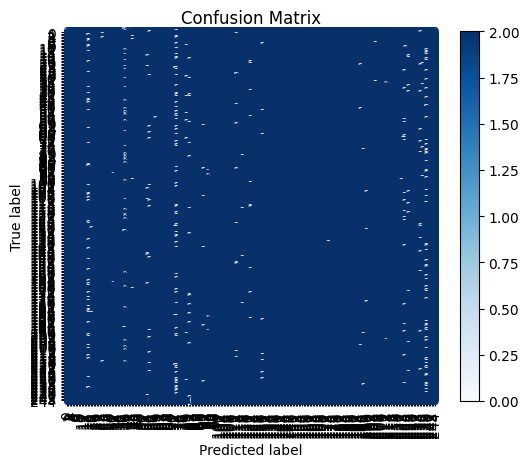

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Tahminlerinizi alın
y_pred_prob = model.predict(X_test)  # Model tahminlerini alın (olasılıklar)
y_pred = np.argmax(y_pred_prob, axis=1)  # Sınıf tahminlerini alın
y_true = np.argmax(y_test, axis=1)  # Gerçek sınıfları alın

# Confusion Matrix oluşturun
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(len(cm)))

# Görselleştirin
plt.figure(figsize=(12, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
cm_all = confusion_matrix(y_true, y_pred)

TP = np.diag(cm_all).sum()
print("True Positives (TP):", TP)

True Positives (TP): 6


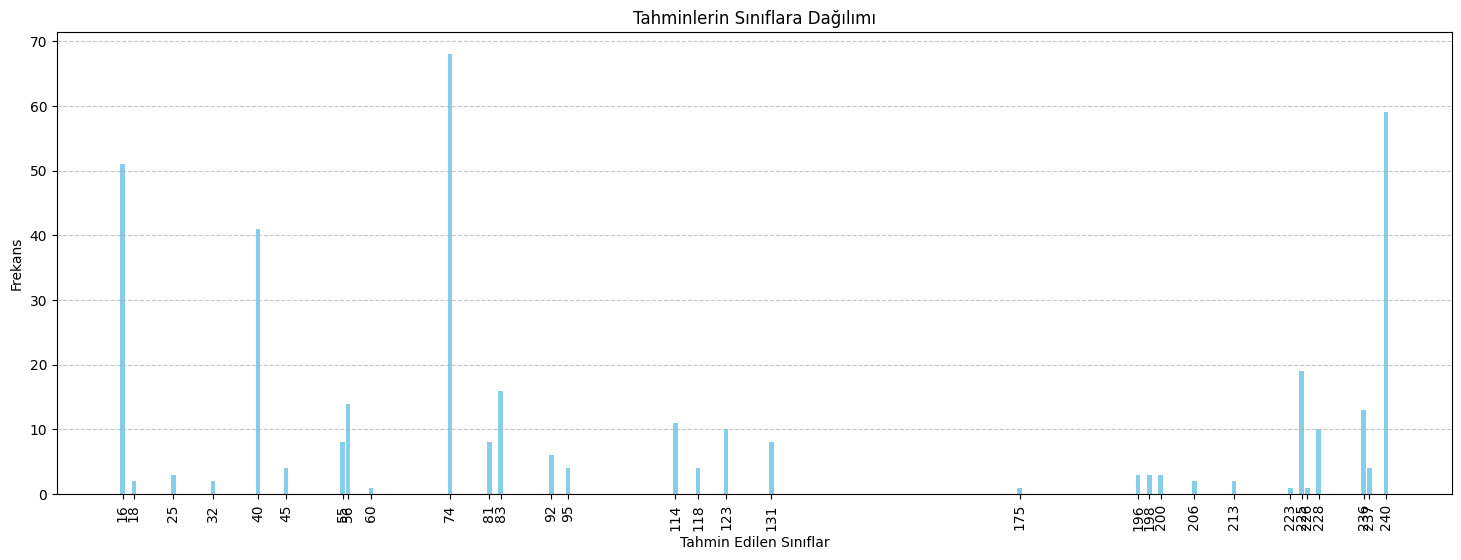

In [ ]:
# Tahmin edilen sınıfların frekanslarını hesaplayın
unique_classes, counts = np.unique(y_pred, return_counts=True)

# Bar plot ile görselleştirin
plt.figure(figsize=(18, 6))
plt.bar(unique_classes, counts, color='skyblue')
plt.xlabel('Tahmin Edilen Sınıflar')
plt.ylabel('Frekans')
plt.title('Tahminlerin Sınıflara Dağılımı')
plt.xticks(unique_classes, rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


ResNet50 katmanlarını değiştirerek yapılan eğitimin sonuçları

In [ ]:
# Görüntüleri RGB'ye dönüştürme
X_train_rgb = np.array([convert_to_rgb(img) for img in X_train])
X_val_rgb = np.array([convert_to_rgb(img) for img in X_val])

# Modeli derleme
# Modeli derle
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # One-hot encoded etiketler için categorical_crossentropy kullanıyoruz
    metrics=['accuracy']
)

# Eğitim ve doğrulama için sadece rescale işlemi
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Eğitim ve doğrulama verilerini hazırla
train_generator = train_datagen.flow(X_train_rgb, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val_rgb, y_val, batch_size=32)

# Modeli eğitme
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,  # Batch size 32
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(X_val) // 32
)



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 148s 5s/step - accuracy: 0.0082 - loss: 5.7615 - val_accuracy: 0.0045 - val_loss: 5.5550
Epoch 2/10
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1:40 4s/step - accuracy: 0.0000e+00 - loss: 5.7129

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.0000e+00 - loss: 5.7129 - val_accuracy: 0.0000e+00 - val_loss: 5.7146
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 194s 5s/step - accuracy: 0.0000e+00 - loss: 5.4696 - val_accuracy: 0.0045 - val_loss: 5.5463
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.0000e+00 - loss: 5.5574 - val_accuracy: 0.0000e+00 - val_loss: 5.5729
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.0046 - loss: 5.4446 - val_accuracy: 0.0045 - val_loss: 5.5496
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.0000e+00 - loss: 5.4611 - val_accuracy: 0.0000e+00 - val_loss: 5.8387
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.0064 - loss: 5.4340 - val_accuracy: 0.0000e+00 - val_loss: 5.5816
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 409ms/step - accuracy: 0.0000e+00 - loss: 5.5969 - val_accuracy: 0.0000e+00 - val_loss: 5.4616
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step - accuracy: 0.0059 - loss: 5.

In [ ]:
# Modeli kaydet

# Modeli Keras formatında kaydet
model.save('/content/iris_detection_model.keras')


In [ ]:
from google.colab import files

# Modeli indirmek için
files.download('/content/test_processed_dataset')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bu aşamada modeldeki sorunu çözemediğimiz için sunum sonrası tekrardan literatür taraması yaptık. 2 farklı yöntem ile projemize devam ettik. Yöntem 2'de de benzer sorunlarla karşılaştığımız için projemizde kullandığımız ve başarılı sonuçlar elde ettiğimiz 3.Yöntemi diğer dosyada bulabilirsiniz.